<a href="https://colab.research.google.com/github/vlozg/aicovid/blob/main/%5BExplore003%5D_AICOVID_115M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook này nhằm mục đích:
- Trực quan khám phá với data final.

# Detect COVID-19 patients via forced-cough cell phone recording

- **Bài toán**: Nhận diện người nhiễm COVID-19 qua tiếng ho ép buộc
    - **Input**: Đoạn ghi âm tiếng ho, tuổi và giới tính
    - **Output**: Phân loại người nhiễm bệnh hay không

## Tìm hiểu bài toán 
Qua paper (https://dspace.mit.edu/bitstream/handle/1721.1/128954/09208795.pdf?sequence=1&isAllowed=y)

# Các biến thiết lập cho thử nghiệm

# Import và cài đặt thư viện

In [ ]:
# cài lib. note: cài xong phải restart runtime
try:
  import torchaudio
except ImportError:
  !pip install torchaudio
  !pip install pytorch-lightning==1.3.8
  !pip install --upgrade matplotlib
  exit()

In [ ]:
# Quản lý file, folder
import os

# Xử lý audio
import librosa

# Hiện audio nghe thử
import IPython.display as ipd
from IPython.display import Audio, display

from tqdm import tqdm

import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchaudio
import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed=1)

Global seed set to 1


1

# Download data and setup folder, meta

In [ ]:
#@markdown ## Warmup data:

# download public train data
# official link: https://drive.google.com/file/d/1MPhz3zYl2yefCq-J5XySbFJt99BfKIZD/view
# personal link: https://drive.google.com/file/d/1hoGLxjLmPY-pX-jSVGIaWIZhovQBMKU1/view?usp=sharing
#@markdown - Public train:
is_download = True #@param {type:"boolean"}
train_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_public_train.zip'):
    !gdown --id 1MPhz3zYl2yefCq-J5XySbFJt99BfKIZD
    !unzip -o -q aicv115m_public_train.zip
    !unzip -n -q aicv115m_public_train/train_audio_files_8k.zip
  train_meta = pd.read_csv('aicv115m_public_train/metadata_train_challenge.csv')
  train_meta['file_path'] = 'train_audio_files_8k/'+train_meta['file_path']

# dowload public test data
# official link: https://drive.google.com/file/d/1UrMudzopA3CyR1Ih2J63Kfi2mY_0uhRK/view
# personal link: https://drive.google.com/file/d/1X7vOjHos9f9w48-iTWyu5JElFqCjcH_R/view?usp=sharing
#@markdown - Public test:
is_download = True #@param {type:"boolean"}
test_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_public_test.zip'):
    !gdown --id 1UrMudzopA3CyR1Ih2J63Kfi2mY_0uhRK
    !unzip -o -q aicv115m_public_test.zip
    !unzip -n -q aicv115m_public_test/public_test_audio_files_8k.zip
  test_meta = pd.read_csv('aicv115m_public_test/metadata_public_test.csv')
  test_meta['file_path'] = 'public_test_audio_files_8k/'+test_meta['file_path']

# download private test data
# official link: https://drive.google.com/file/d/1hP8rHwJ_bz3J1T4MtEEp53ZBe9fdFKrW/view
# personal link: https://drive.google.com/file/d/1Ec64sSm2dZqe3da_LVyE_jUBD0DnLyqB/view?usp=sharing
#@markdown - Private test:
is_download = True #@param {type:"boolean"}
private_test_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_private_test.zip'):
    !gdown --id 1Ec64sSm2dZqe3da_LVyE_jUBD0DnLyqB
    !unzip -o -q aicv115m_private_test.zip
  private_test_meta = pd.read_csv('aicv115m_private_test/metadata_private_test.csv')
  private_test_meta['file_path'] = 'aicv115m_private_test/private_test_audio_files_8k/'+private_test_meta['file_path']

#
# Warmup
#
##################################################################################
#
# Final
#
#@markdown ## Final data:

# dowload final train data
# official link: https://drive.google.com/file/d/1Oq9UgA9cEGMNRGvF7oNKkFOg6udsDprl/view
# personal link: https://drive.google.com/file/d/1HoRJllAfYNeBPoCz2nXkf7lQ3raPcFYf/view?usp=sharing
#@markdown - Public train:
is_download = True #@param {type:"boolean"}
final_train_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_final_public_train.zip'):
    !gdown --id 1HoRJllAfYNeBPoCz2nXkf7lQ3raPcFYf
    !unzip -o -q aicv115m_final_public_train.zip
  final_train_meta = pd.read_csv('aicv115m_final_public_train/public_train_metadata.csv')
  final_train_med_meta = pd.read_csv("aicv115m_final_public_train/public_train_medical_condition.csv")
  final_train_meta['file_path'] = 'aicv115m_final_public_train/public_train_audio_files/'+final_train_meta['uuid']+'.wav'

# download final public test data
# official link: https://drive.google.com/file/d/159SghfGeqVj3AfgTRZXsAAAj0-3ogccX/view
# personal link: https://drive.google.com/file/d/1w5N5prH-uWqLvoSZnuY8TIqm_BBgN2ND/view?usp=sharing
#@markdown - Public test:
is_download = True #@param {type:"boolean"}
final_test_meta = None
if is_download:
  if not os.path.isfile('./aicv115m_final_public_test.zip'):
    !gdown --id 1w5N5prH-uWqLvoSZnuY8TIqm_BBgN2ND
    !unzip -o -q aicv115m_final_public_test.zip
  print("Warning: final public test set doesn't have metadata.")
  final_test_meta = pd.read_csv('aicv115m_final_public_test/public_test_sample_submission.csv').drop("assessment_result", axis=1)
final_test_meta['file_path'] = 'aicv115m_final_public_test/public_test_audio_files/'+final_test_meta['uuid']+'.wav'

# Preview all dataframes

In [ ]:
display(train_meta.shape)
train_meta.head()

(1199, 5)

uuid  ...                                          file_path
0  3284bcf1-2446-4f3a-ac66-14c76b294177  ...  train_audio_files_8k/3284bcf1-2446-4f3a-ac66-1...
1  431334e1-5946-4576-bb51-8e342ccc22b4  ...  train_audio_files_8k/431334e1-5946-4576-bb51-8...
2  1d6fac4b-1e7f-4bdc-81cd-3a720bfbb1e1  ...  train_audio_files_8k/1d6fac4b-1e7f-4bdc-81cd-3...
3  c7ee0695-b2e7-4beb-b904-f1455c9609d9  ...  train_audio_files_8k/c7ee0695-b2e7-4beb-b904-f...
4  dd541704-b696-4181-8fd8-816daac0fcf9  ...  train_audio_files_8k/dd541704-b696-4181-8fd8-8...

[5 rows x 5 columns]

In [ ]:
display(test_meta.shape)
test_meta.head()

(350, 4)

uuid  ...                                          file_path
0  66ef1f05-fbb0-44cb-8bdb-8eb4df83359a  ...  public_test_audio_files_8k/66ef1f05-fbb0-44cb-...
1  73d13a12-f9bc-4554-af49-be24f6024a25  ...  public_test_audio_files_8k/73d13a12-f9bc-4554-...
2  d27dbe98-e061-4018-9900-d1f1d47feab1  ...  public_test_audio_files_8k/d27dbe98-e061-4018-...
3  43c30e4c-5d35-4ebc-8235-8920b7688550  ...  public_test_audio_files_8k/43c30e4c-5d35-4ebc-...
4  1952aa84-d077-495d-a1a9-9686a30722e0  ...  public_test_audio_files_8k/1952aa84-d077-495d-...

[5 rows x 4 columns]

In [ ]:
display(private_test_meta.shape)
private_test_meta.head()

(450, 4)

uuid  ...                                          file_path
0  bce020a3-6ab7-46df-8a75-7f8009a1883e  ...  aicv115m_private_test/private_test_audio_files...
1  efe397fd-5ff1-41d8-b991-b8acdafd663c  ...  aicv115m_private_test/private_test_audio_files...
2  5954077a-4c41-4a2e-9cad-e3bb2d6402c4  ...  aicv115m_private_test/private_test_audio_files...
3  2b330c25-0816-480a-bb87-9d3d0d632c0c  ...  aicv115m_private_test/private_test_audio_files...
4  bfa78793-b3b8-42b8-bad0-77e3c55abfda  ...  aicv115m_private_test/private_test_audio_files...

[5 rows x 4 columns]

In [ ]:
display(final_train_meta.shape)
final_train_meta.head()

(4504, 7)

uuid  ...                                          file_path
0  fc802bee-ef01-4496-a898-d7e77c0017e9  ...  aicv115m_final_public_train/public_train_audio...
1  9341db3f-049a-4ceb-8438-87ca1618a18a  ...  aicv115m_final_public_train/public_train_audio...
2  307e7a8b-b312-409e-ac01-75e1260b0a95  ...  aicv115m_final_public_train/public_train_audio...
3  ff8c21a8-4d05-43d8-96ee-dd33bcd6461e  ...  aicv115m_final_public_train/public_train_audio...
4  2e9d68e1-e84e-4aa5-8199-e7b0bbe6969f  ...  aicv115m_final_public_train/public_train_audio...

[5 rows x 7 columns]

In [ ]:
display(final_test_meta.shape)
final_test_meta.head()

(1233, 2)

uuid                                          file_path
0  7b3797b0-3b7e-41e3-8b28-e2717eb55f8b  aicv115m_final_public_test/public_test_audio_f...
1  f0c466b3-7bf2-47e4-9e7f-f8cfc1783764  aicv115m_final_public_test/public_test_audio_f...
2  a2d668e9-d876-4bf6-bcb3-0cc32ba20c84  aicv115m_final_public_test/public_test_audio_f...
3  0edbea61-da70-44a4-8ee8-3681027944a6  aicv115m_final_public_test/public_test_audio_f...
4  1bcee200-1c33-4293-b1e9-5854210d92e8  aicv115m_final_public_test/public_test_audio_f...

In [ ]:
display(final_train_med_meta.shape)
final_train_med_meta.head()

(910, 5)

uuid  ... insomnia_status_choice
0  6196bae2-a8d1-4859-be7b-6070b7c8478e  ...                     No
1  7fb359ae-c7ff-49d9-a336-4137ac336c9c  ...                     No
2  2269030d-fa24-4cb5-b810-eaa6c39e4a4e  ...                     No
3  1c446a50-0bb9-4ad0-9bf0-575253a42be1  ...                     No
4  81311ddc-ac9f-45de-845e-4aad5004a4cc  ...                     No

[5 rows x 5 columns]

# Merge metadata, convert string to object in final train dataset

Some string have the format of list or dictionary, so we need to convert to make future work convinient.

In [ ]:
final_train_meta_merge = final_train_meta.merge(final_train_med_meta, how="left", on="uuid")

In [ ]:
import ast
str_to_obj = lambda x: ast.literal_eval(x)
col_tobe_processed = ['cough_intervals', 'symptoms_status_choice', 'medical_condition_choice',]

for col in col_tobe_processed:
    final_train_meta_merge[col] = final_train_meta_merge[col].map(str_to_obj, na_action='ignore')

In [ ]:
final_train_meta_merge

uuid  ... insomnia_status_choice
0     fc802bee-ef01-4496-a898-d7e77c0017e9  ...                     No
1     9341db3f-049a-4ceb-8438-87ca1618a18a  ...                    NaN
2     307e7a8b-b312-409e-ac01-75e1260b0a95  ...                     No
3     ff8c21a8-4d05-43d8-96ee-dd33bcd6461e  ...                    NaN
4     2e9d68e1-e84e-4aa5-8199-e7b0bbe6969f  ...                     No
...                                    ...  ...                    ...
4499  7e260fb9-7eb1-4433-99e0-dbbc05d2f2b2  ...                    NaN
4500  c936f1a1-f6cf-48e5-82a1-872a58b6fd01  ...                    NaN
4501  bacedca5-4147-4e87-ad70-2f0eb98f062d  ...                    NaN
4502  90a9d310-0a13-493f-b476-c961a2d0c8c9  ...                    NaN
4503  f616cb8d-370f-43e6-b459-121a9b987c94  ...                    NaN

[4504 rows x 11 columns]

# Hàm xử lý âm thanh

Các hàm vỏ bọc cho đọc file

In [ ]:
#@markdown ## Các hàm vỏ bọc cho đọc file
#@markdown `read_audio(path)`: vỏ bọc cho `torchaudio.load(path)`.<br>
#@markdown `read_resample_audio(path)`: chỉ trả về wave vì sample rate đã được cố định.

'''
  Read audio from given path and return (wave, sample_rate)
'''
def read_audio(full_audio_path):
  return torchaudio.load(full_audio_path)

'''
  Read audio from given path, then resample if sample rate is not matched 
  and return wave.

  Tips: 
    you should provide resampler from torchaudio.transform
    when batch resampling with same params since this can
    give a huge speed up.
'''
def read_resample_audio(
    full_audio_path, resample,
    resampler=None
):
  wave, sr = torchaudio.load(full_audio_path)
  if resampler is not None:
      wave = resampler(wave)
  elif sr != resample:
      wave = torchaudio.functional.resample(wave, sr, resample)
  return wave

In [ ]:
# Spectrogram transformation
n_fft = 2048
win_length = 160
hop_length = 80
n_mels = 200
n_mfcc = 200

In [ ]:
#@markdown `spectrogram(waveform)` --> spec 
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    normalized=True,
    pad_mode="reflect",
    power=2.0,
)

#@markdown `mel_spectrogram(waveform)` --> mel_spec 
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    #norm='slaney',
    onesided=True,
    normalized=True,
    n_mels=n_mels,
    mel_scale="htk",
)

#@markdown `log_spectrogram(spec)` --> log(spec)
log_spectrogram = torchaudio.transforms.AmplitudeToDB(
    stype='power',
    top_db=80
)

In [ ]:
#@markdown `mfcc_transform(waveform)` --> MFCC

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=8000,
    n_mfcc=n_mfcc,
    log_mels=True,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'win_length': win_length,
      'normalized': True,
      'mel_scale': 'htk'
    }
)

#@markdown `delta_transform(mfcc_transform(waveform))` --> delta MFCC

delta_transform = torchaudio.transforms.ComputeDeltas(
    win_length = 5, 
    mode = 'replicate'
)

In [ ]:
#@markdown `griffin_lim(spec)` --> waveform
griffin_lim = torchaudio.transforms.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length
)

In [ ]:
#@markdown `StandardScaler()`
class StandardScaler(torch.nn.Module):
    def __init__(self) -> None:
        super(StandardScaler, self).__init__()
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return ((spec-spec.mean())/spec.std()).nan_to_num(posinf=0.0, neginf=0.0)

#@markdown `MinMaxScaler()`
class MinMaxScaler(torch.nn.Module):
    def __init__(self) -> None:
        super(MinMaxScaler, self).__init__()
        
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        return ((spec-spec.min())/(spec.max()-spec.min())).nan_to_num(posinf=0.0, neginf=0.0)

# Các hàm bổ trợ trực quan audio

In [ ]:
[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

In [ ]:
#@markdown Vẽ specgram (specgram chỉ đơn giản là apply discrete-time Fourier transform)
#@markdown `plot_specgram(wave, sr, title, xlim, ylim)`
def plot_specgram(waveform, sample_rate, fig=None, title="Spectrogram", xlim=None):
  
  # Chuẩn hóa dữ liệu khi input có thể có 1 hoặc 2 chiều, với chiều 0 là channel
  if len(waveform.shape) == 1:
    num_channels = 1
    num_frames = waveform.shape[0]
    _waveform = [waveform]
  elif len(waveform.shape) == 2:
    num_channels, num_frames = waveform.shape
    _waveform = waveform
  
  time_axis = torch.arange(0, num_frames) / sample_rate

  # Khởi tạo subplot
  if fig is None:
    fig, axs = plt.subplots(num_channels, 1)
  else:
    axs = fig.subplots(num_channels, 1)

  # Chuẩn hóa axs vì 1 channel subplot không return list
  if num_channels == 1:
    axs = [axs]

  # Plot specgram for each channel
  for i in range(num_channels):
    axs[i].specgram(waveform[i], Fs=sample_rate)
    if xlim:
      axs[i].set_xlim(xlim)
  
  fig.suptitle(title)

In [ ]:
#@markdown Vẽ waveform `plot_waveform(wave, sr, fig, title, xlim, ylim)`
def plot_waveform(waveform, sample_rate, fig=None, title="Waveform", xlim=None, ylim=None):

  # Chuẩn hóa dữ liệu khi input có thể có 1 hoặc 2 chiều, với chiều 0 là channel
  if len(waveform.shape) == 1:
    num_channels = 1
    num_frames = waveform.shape[0]
    _waveform = [waveform]
  elif len(waveform.shape) == 2:
    num_channels, num_frames = waveform.shape
    _waveform = waveform
  
  time_axis = torch.arange(0, num_frames) / sample_rate

  # Khởi tạo subplot
  if fig is None:
    fig, axs = plt.subplots(num_channels, 1)
  else:
    axs = fig.subplots(num_channels, 1)

  # Chuẩn hóa axs vì 1 channel subplot không return list
  if num_channels == 1:
    axs = [axs]

  # Plot waveform
  for i in range(num_channels):
    axs[i].plot(time_axis, waveform[i], linewidth=1)
    axs[i].grid(True)
    if xlim:
      axs[i].set_xlim(xlim)
    if ylim:
      axs[i].set_ylim(ylim)
  
  fig.suptitle(title)

In [ ]:
#@markdown Vẽ spectrogram `plot_spectrogram(spec, fig, axs, title, ylabel, aspect, xmax, to_db)`
def plot_spectrogram(spec, fig=None, title=None, ylabel='freq_bin', aspect='auto', xmax=None, to_db=True):
  
  # Chuẩn hóa dữ liệu khi input có thể có 1 hoặc 2 chiều, với chiều 0 là channel
  if len(spec.shape) == 2:
    num_channels = 1
    _spec = [spec]
  elif len(spec.shape) == 3:
    num_channels = spec.shape[0]
    _spec = spec

  # Khởi tạo subplot
  if fig is None:
    fig, axs = plt.subplots(num_channels, 1)
  else:
    axs = fig.subplots(num_channels, 1)

  # Chuẩn hóa axs vì 1 channel subplot không return list
  if num_channels == 1:
    axs = [axs]

  fig.suptitle(title or 'Spectrogram (db)')

  for i in range(num_channels):
    axs[i].set_ylabel(ylabel)
    axs[i].set_xlabel('frame')
    im = axs[i].imshow(log_spectrogram(_spec[i]) if to_db else _spec[i], 
                       origin='lower', 
                       aspect=aspect)
    if xmax:
      axs[i].set_xlim((0, xmax))
  
  fig.colorbar(im, ax=axs)

In [ ]:
#@markdown Hiển thị audio box `play_audio(wave, sr)`
def play_audio(waveform, sample_rate):

  if len(waveform.shape) == 1:
    display(Audio(waveform, rate=sample_rate))
    return
  
  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

#@markdown Hiển thị audio box `play_audio_from_spec(spec, sample_rate)`
def play_audio_from_spec(spec, sample_rate):
  waveform = griffin_lim(spec)

  play_audio(waveform, sample_rate)

Hàm lấy mẫu data random

In [ ]:
def get_covid_samples(train_meta, n_samples):
  df = train_meta[train_meta['assessment_result'] == 1]
  idxs = random.sample(range(len(df)), n_samples)
  return df.iloc[idxs]

def get_nocovid_samples(train_meta, n_samples):
  df = train_meta[train_meta['assessment_result'] == 0]
  idxs = random.sample(range(len(df)), n_samples)
  return df.iloc[idxs]

# Khám phá dữ liệu

## Khám phá thiếu

In [ ]:
train_meta.isna().sum()/train_meta.shape[0]

uuid                 0.000000
subject_gender       0.423686
subject_age          0.461218
assessment_result    0.000000
file_path            0.000000
dtype: float64

In [ ]:
test_meta.isna().sum()/test_meta.shape[0]

uuid              0.000000
subject_gender    0.271429
subject_age       0.300000
file_path         0.000000
dtype: float64

In [ ]:
private_test_meta.isna().sum()/private_test_meta.shape[0]

uuid              0.000000
subject_gender    0.244444
subject_age       0.257778
file_path         0.000000
dtype: float64

In [ ]:
final_train_meta.isna().sum()/final_train_meta.shape[0]

uuid                 0.000000
subject_age          0.000000
subject_gender       0.000000
audio_noise_note     0.898757
cough_intervals      0.202043
assessment_result    0.000000
file_path            0.000000
dtype: float64

In [ ]:
final_train_med_meta.isna().sum()/final_train_med_meta.shape[0]

uuid                        0.0
symptoms_status_choice      0.0
medical_condition_choice    0.0
smoke_status_choice         0.0
insomnia_status_choice      0.0
dtype: float64

## Khám phá phân lớp

In [ ]:
train_meta['assessment_result'].value_counts()

0    737
1    462
Name: assessment_result, dtype: int64

In [ ]:
final_train_meta['assessment_result'].value_counts()

0    3825
1     679
Name: assessment_result, dtype: int64

# Khám phá âm thanh

In [ ]:
n_samples = 5

In [ ]:
#@markdown Đọc `n_samples` mẫu audio cho mỗi class
sample_noCOVID_metas = get_nocovid_samples(final_train_meta_merge, n_samples)
sample_COVID_metas = get_covid_samples(final_train_meta_merge, n_samples)
sample_COVID_files = sample_COVID_metas['file_path']
sample_noCOVID_files = sample_noCOVID_metas['file_path']

sample_noCOVIDs = []
sample_COVIDs = []

for file in sample_noCOVID_files:
  wave, sr = read_audio(file)
  sample_noCOVIDs.append({'wave': wave, 'sr': sr})

for file in sample_COVID_files:
  wave, sr = read_audio(file)
  sample_COVIDs.append({'wave': wave, 'sr': sr})

Sample 0, Size (torch.Size([1, 196608])), Sample rate 48000


uuid                                     b1846016-e5d4-44d9-9202-fef20e6b9046
subject_age                                                       group_19_33
subject_gender                                                           male
audio_noise_note                                                          NaN
cough_intervals             [{'end': 1.764836012861736, 'start': 1.4224051...
assessment_result                                                           0
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 650, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


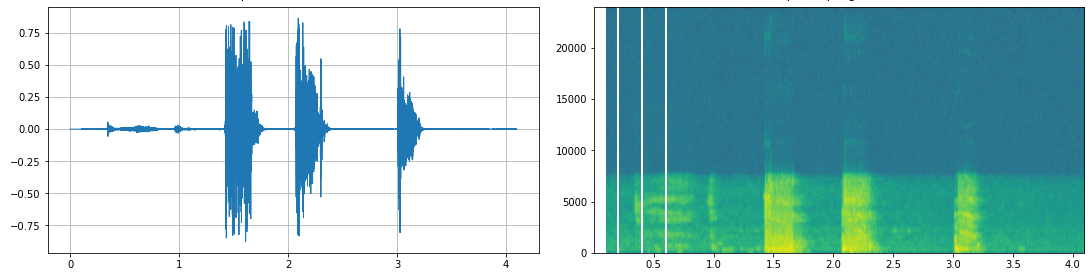

Sample 1, Size (torch.Size([1, 212992])), Sample rate 48000


uuid                                     8c6234df-9b9e-4075-9702-c2f209209baa
subject_age                                                       group_19_33
subject_gender                                                           male
audio_noise_note                                                          NaN
cough_intervals             [{'start': 0.6427191966010041, 'end': 0.879239...
assessment_result                                                           0
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 2715, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


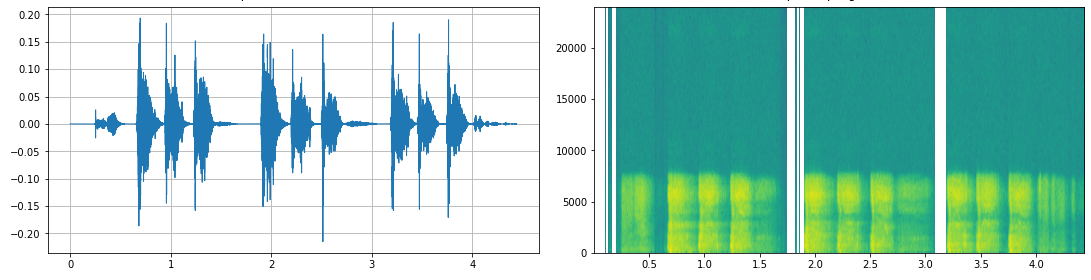

Sample 2, Size (torch.Size([1, 409600])), Sample rate 48000


uuid                                     1f82a009-679a-4a0b-a95d-1465ea0763e5
subject_age                                                       group_19_33
subject_gender                                                         female
audio_noise_note                                                          NaN
cough_intervals             [{'end': 3.443905865823674, 'start': 2.0411661...
assessment_result                                                           0
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 4072, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


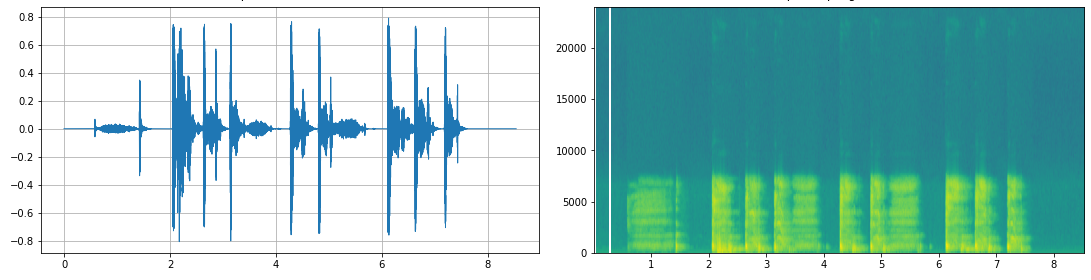

Sample 3, Size (torch.Size([1, 219136])), Sample rate 8000


uuid                                     5a91b9d9-7c72-4440-828f-e05c80b17dde
subject_age                                                       group_19_33
subject_gender                                                           male
audio_noise_note                                                          NaN
cough_intervals                                                           NaN
assessment_result                                                           0
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                   [No]
medical_condition_choice                                                 [No]
smoke_status_choice                                                     never
insomnia_status_choice                                                     No
Name: 3853, dtype: object

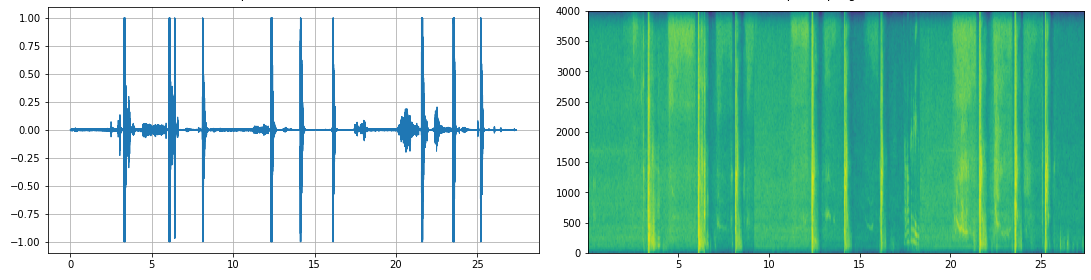

Sample 4, Size (torch.Size([1, 200704])), Sample rate 48000


uuid                                     6932d72e-34c8-4c34-84dc-d4363e10f72f
subject_age                                                       group_19_33
subject_gender                                                           male
audio_noise_note                                                          NaN
cough_intervals             [{'end': 1.476792755137582, 'start': 1.2539630...
assessment_result                                                           0
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 3661, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


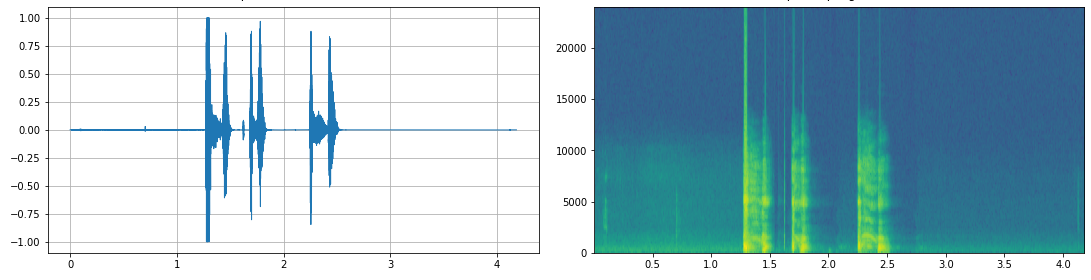

In [ ]:
#@markdown ## Các mẫu audio không COVID
for idx, a in enumerate(sample_noCOVIDs):
  print(f'Sample {idx}, Size ({a["wave"].shape}), Sample rate {a["sr"]}')
  display(sample_noCOVID_metas.iloc[idx])
  fig = plt.figure(constrained_layout=True)
  subfigs = fig.subfigures(1, 2).flat
  
  play_audio(a['wave'], a['sr'])
  plot_waveform(a['wave'], a['sr'], subfigs[0], title=f'Sample {idx} waveform')
  plot_specgram(a['wave'], a['sr'], subfigs[1], title=f'Sample {idx} specgram')
  plt.show(block=False)

Sample 0, Size (torch.Size([1, 323584])), Sample rate 48000


uuid                                     5288dbc0-3007-4d74-9b8f-2a3ce03f42b9
subject_age                                                       group_49_64
subject_gender                                                         female
audio_noise_note                                                          NaN
cough_intervals             [{'start': 0.8418248418248411, 'end': 1.252635...
assessment_result                                                           1
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 434, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


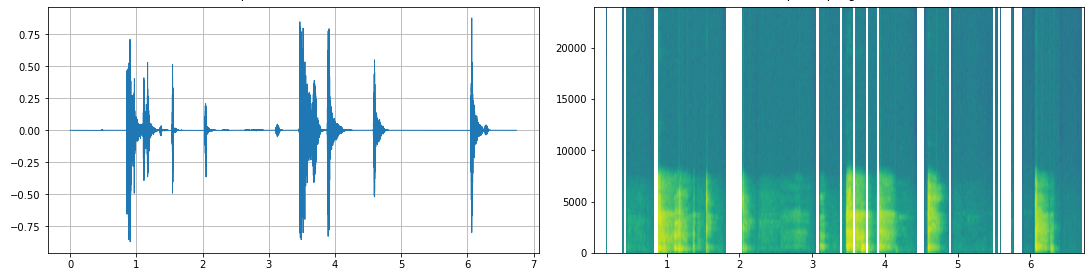

Sample 1, Size (torch.Size([1, 60212])), Sample rate 22050


uuid                                     8d639a80-50c5-43fb-b8a1-2303828b2021
subject_age                                                       group_19_33
subject_gender                                                         female
audio_noise_note                                                          NaN
cough_intervals             [{'end': 1.219388611388611, 'start': 0.9602344...
assessment_result                                                           1
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 1840, dtype: object

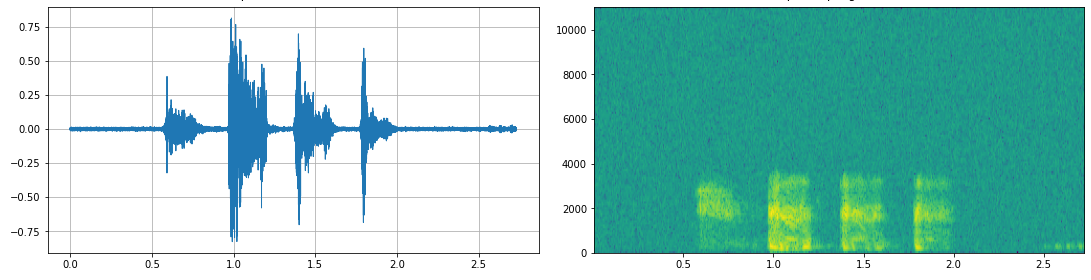

Sample 2, Size (torch.Size([1, 116660])), Sample rate 22050


uuid                                     9cc30213-a9f4-4aba-bfc7-7a4af55067ba
subject_age                                                       group_19_33
subject_gender                                                         female
audio_noise_note                                                          NaN
cough_intervals             [{'end': 1.022053092532768, 'start': 0.1585057...
assessment_result                                                           1
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 782, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


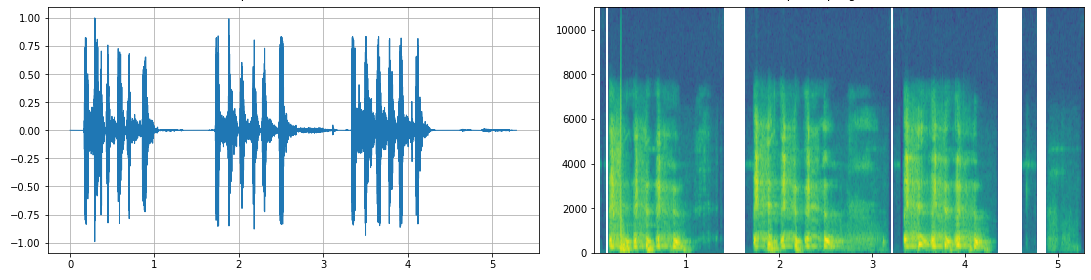

Sample 3, Size (torch.Size([1, 301056])), Sample rate 22050


uuid                                     56f3669b-90dd-4ac4-bd3c-7e4578ecc9c7
subject_age                                                       group_19_33
subject_gender                                                         female
audio_noise_note                                                          NaN
cough_intervals             [{'end': 1.991395271395271, 'start': 1.3912487...
assessment_result                                                           1
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 3494, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


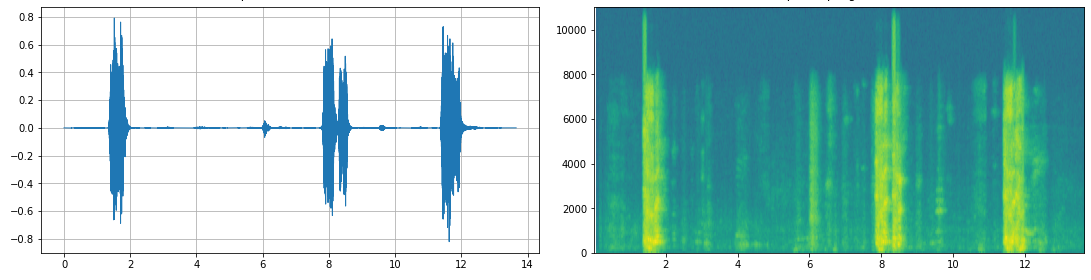

Sample 4, Size (torch.Size([1, 86554])), Sample rate 22050


uuid                                     253412ca-a086-470e-b3ed-5b4ced9ab267
subject_age                                                       group_19_33
subject_gender                                                           male
audio_noise_note                                                          NaN
cough_intervals             [{'end': 1.329486992870574, 'start': 0.4828464...
assessment_result                                                           1
file_path                   aicv115m_final_public_train/public_train_audio...
symptoms_status_choice                                                    NaN
medical_condition_choice                                                  NaN
smoke_status_choice                                                       NaN
insomnia_status_choice                                                    NaN
Name: 3204, dtype: object

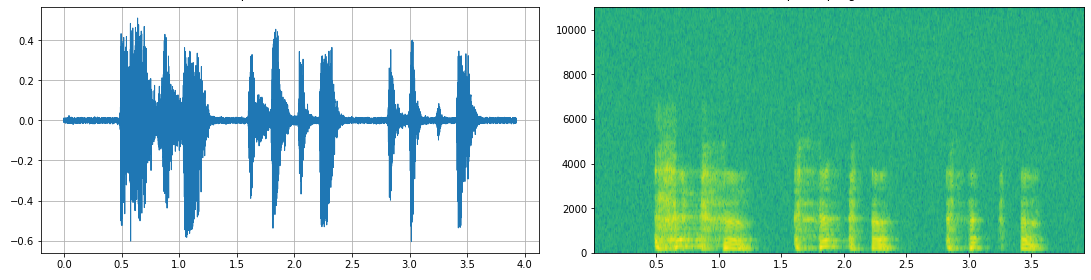

In [ ]:
#@markdown ## Các mẫu audio có COVID
for idx, a in enumerate(sample_COVIDs):
  print(f'Sample {idx}, Size ({a["wave"].shape}), Sample rate {a["sr"]}')
  display(sample_COVID_metas.iloc[idx])
  fig = plt.figure(constrained_layout=True)
  subfigs = fig.subfigures(1, 2).flat
  
  play_audio(a['wave'], a['sr'])
  plot_waveform(a['wave'], a['sr'], subfigs[0], title=f'Sample {idx} waveform')
  plot_specgram(a['wave'], a['sr'], subfigs[1], title=f'Sample {idx} specgram')
  plt.show(block=False)

torch.Size([1, 1025, 2458])
torch.Size([1, 1025, 2663])
torch.Size([1, 1025, 5121])
torch.Size([1, 1025, 2740])
torch.Size([1, 1025, 2509])
torch.Size([1, 1025, 4045])
torch.Size([1, 1025, 753])
torch.Size([1, 1025, 1459])
torch.Size([1, 1025, 3764])
torch.Size([1, 1025, 1082])


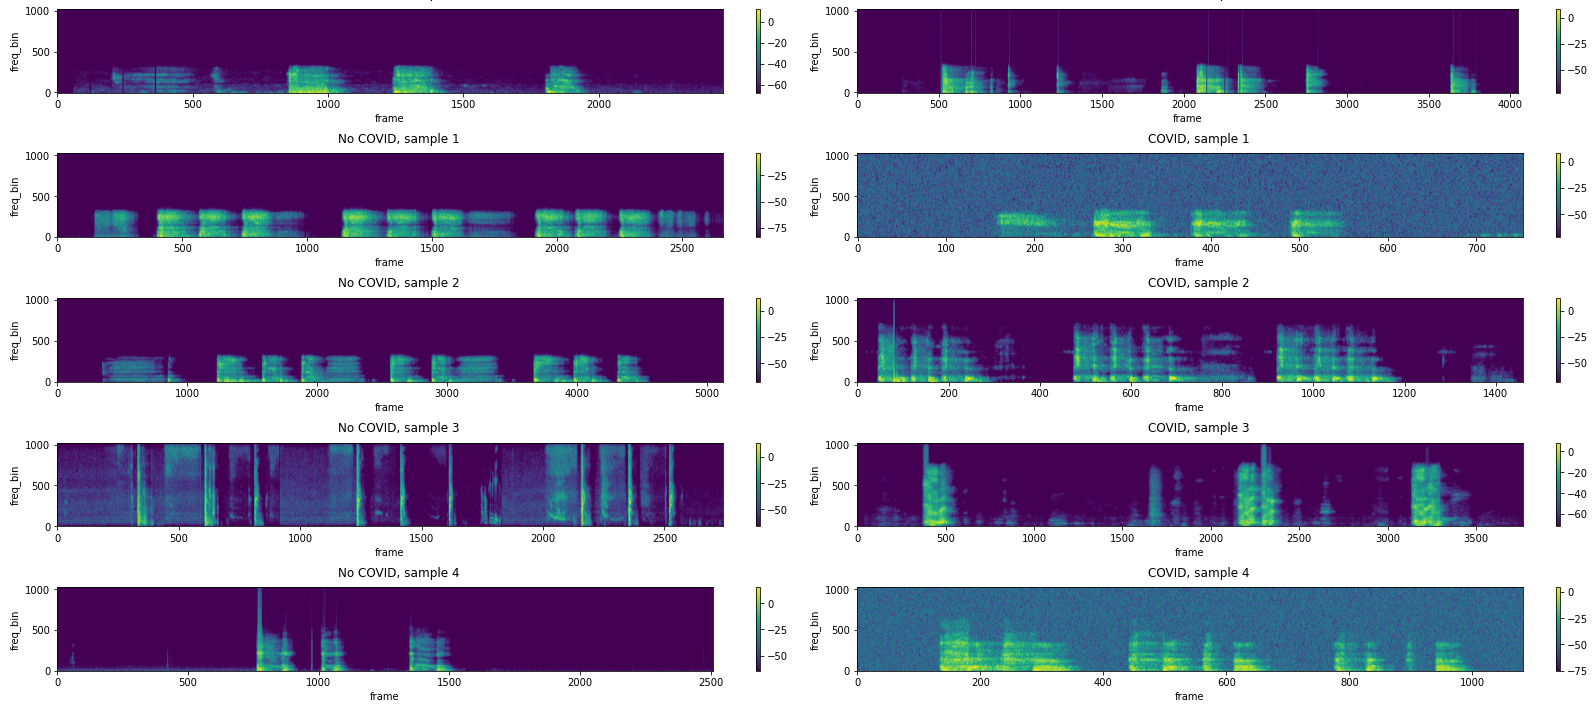

In [ ]:
#@markdown ## So sánh spectrogram
fig = plt.figure(constrained_layout=True, figsize=(22, 10))
subfigs = fig.subfigures(n_samples, 2)

for i, sample in enumerate(sample_noCOVIDs):
  spec = spectrogram(sample['wave'])
  print(spec.size())
  plot_spectrogram(spec, subfigs[i, 0], f'No COVID, sample {i}')
for i, sample in enumerate(sample_COVIDs):
  spec = spectrogram(sample['wave'])
  print(spec.size())
  plot_spectrogram(spec, subfigs[i, 1], f'COVID, sample {i}')

fig.show()

torch.Size([1, 200, 2458])
torch.Size([1, 200, 2663])
torch.Size([1, 200, 5121])
torch.Size([1, 200, 2740])
torch.Size([1, 200, 2509])
torch.Size([1, 200, 4045])
torch.Size([1, 200, 753])
torch.Size([1, 200, 1459])
torch.Size([1, 200, 3764])
torch.Size([1, 200, 1082])


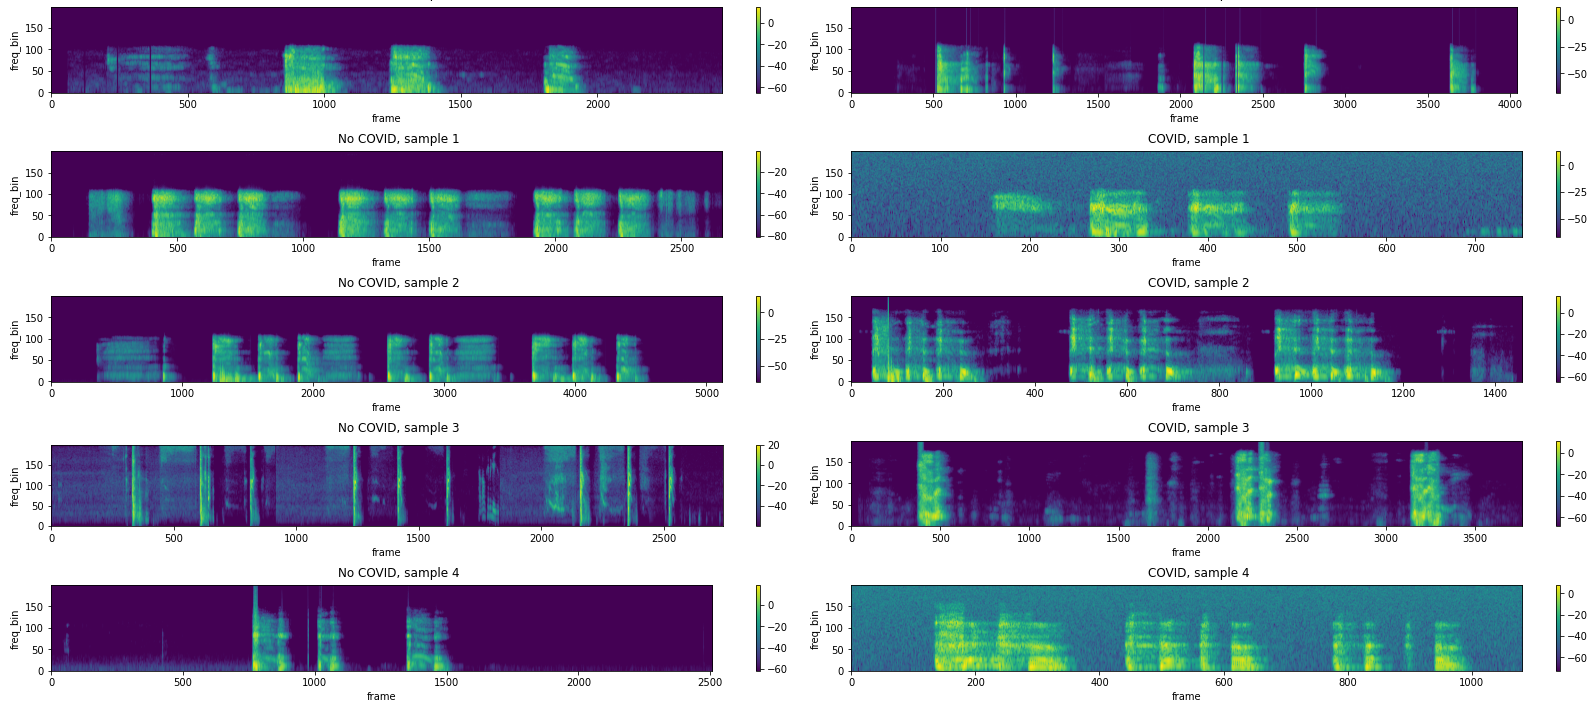

In [ ]:
#@markdown ## So sánh mel spectrogram
fig = plt.figure(constrained_layout=True, figsize=(22, 10))
subfigs = fig.subfigures(n_samples, 2)

for i, sample in enumerate(sample_noCOVIDs):
  spec = mel_spectrogram(sample['wave'])
  print(spec.size())
  plot_spectrogram(spec, subfigs[i, 0], f'No COVID, sample {i}')
for i, sample in enumerate(sample_COVIDs):
  spec = mel_spectrogram(sample['wave'])
  print(spec.size())
  plot_spectrogram(spec, subfigs[i, 1], f'COVID, sample {i}')

fig.show()

# Nhận xét 01
Sau khi xem qua audio:
- Các file audio có sample rate khác nhau. Tuy nhiên âm phổ lại có vẻ như bị upsample lên (bị cắt ngang).
- Có file clean, có file noise.
- `cough_intervals` NaN không có nghĩa file đó không có tiếng ho
- Nếu chunking rất dễ có khả năng bị dính khoảng không có tiếng ho.

# Khám phá phân bố dữ liệu đơn biến trong final train dataset

Tuổi

group_0_2        11
group_3_5         2
group_6_13       14
group_14_18     150
group_19_33    2796
group_34_48     944
group_49_64     507
group_65_78      74
group_79_98       6
Name: subject_age, dtype: int64

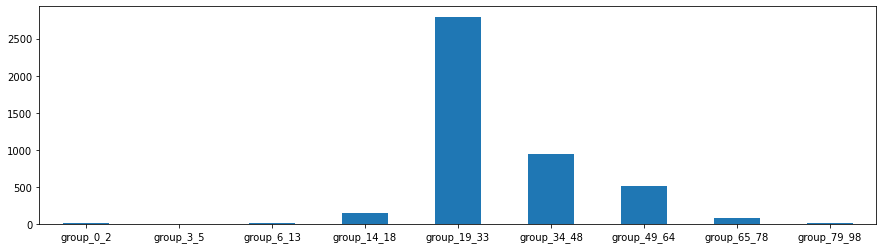

In [ ]:
age_counts = final_train_meta_merge['subject_age'].value_counts()
age_counts = age_counts.reindex(['group_0_2', 'group_3_5', 'group_6_13', 'group_14_18', 'group_19_33', 'group_34_48', 'group_49_64', 'group_65_78', 'group_79_98'])
age_counts.plot.bar(rot=0)
age_counts

Giới tính

male      3166
female    1338
Name: subject_gender, dtype: int64

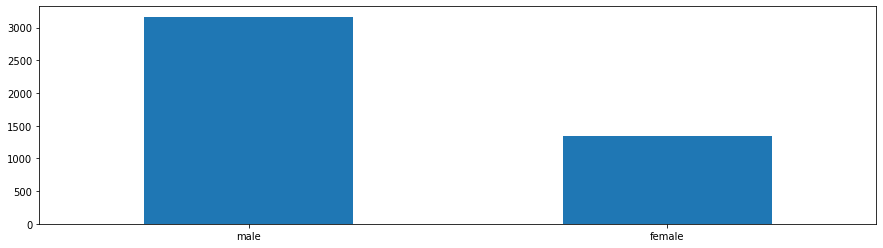

In [ ]:
gender_counts = final_train_meta_merge['subject_gender'].value_counts()
gender_counts.plot.bar(rot=0)
gender_counts

Audio noise note (có lẽ cột này có ích khi inspect kết quả predict từ model, hoặc nếu dùng được kỹ thuật text mining thì mới có ích)

In [ ]:
final_train_meta_merge['audio_noise_note'].value_counts()

không                                                 78
không nhận dạng được                                  13
có tiếng người nói                                     9
nhiễu không xác định ở đầu âm thanh (âm thanh yếu)     8
không rõ                                               8
                                                      ..
nhiều người nói                                        1
rung điện thoại                                        1
nhiêu ở phần đầu                                       1
có một chút tiếng ồn ở đầu đoạn ghi âm                 1
bản ghi âm này có thở, ho, nguyên âm và số đếm!        1
Name: audio_noise_note, Length: 221, dtype: int64

In [ ]:
final_train_meta_merge['symptoms_status_choice'].apply(lambda x: pd.Series(x).value_counts()).sum()

No                815.0
chills              7.0
dizziness           3.0
drycough           28.0
fever              15.0
headache           26.0
muscleache          6.0
shortbreath         2.0
smelltasteloss      2.0
snivel             23.0
sorethroat         22.0
stuffynose         21.0
tightness           4.0
wetcough           17.0
dtype: float64

In [ ]:
final_train_meta_merge['medical_condition_choice'].apply(lambda x: pd.Series(x).value_counts()).sum()

No            874.0
angina          3.0
asthma          8.0
diabetes        2.0
hbp             5.0
hiv             2.0
longterm       18.0
organ           1.0
otherHeart      2.0
stroke          2.0
dtype: float64

In [ ]:
final_train_meta_merge['smoke_status_choice'].value_counts()

never     845
ex         27
1to10      17
ltOnce     13
21+         3
11to20      3
ecig        2
Name: smoke_status_choice, dtype: int64

In [ ]:
final_train_meta_merge['insomnia_status_choice'].value_counts()

No               867
Onceper2Weeks     19
2to3              10
1                 10
4+                 4
Name: insomnia_status_choice, dtype: int64

In [ ]:
pd.crosstab(final_train_meta_merge['smoke_status_choice'], final_train_meta_merge['assessment_result'])

assessment_result      0   1
smoke_status_choice         
11to20                 3   0
1to10                 17   0
21+                    3   0
ecig                   2   0
ex                    25   2
ltOnce                11   2
never                835  10

In [ ]:
pd.crosstab(final_train_meta_merge['insomnia_status_choice'], final_train_meta_merge['assessment_result'])

assessment_result         0   1
insomnia_status_choice         
1                        10   0
2to3                     10   0
4+                        3   1
No                      857  10
Onceper2Weeks            16   3

In [ ]:
pd.crosstab(final_train_meta_merge['subject_gender'], final_train_meta_merge['assessment_result'])

assessment_result     0    1
subject_gender              
female             1049  289
male               2776  390

In [ ]:
age_assessment_counts = pd.crosstab(final_train_meta_merge['subject_age'], final_train_meta_merge['assessment_result']).reindex(['group_0_2', 'group_3_5', 'group_6_13', 'group_14_18', 'group_19_33', 'group_34_48', 'group_49_64', 'group_65_78', 'group_79_98'])
age_assessment_counts

assessment_result     0    1
subject_age                 
group_0_2            11    0
group_3_5             2    0
group_6_13           14    0
group_14_18         144    6
group_19_33        2432  364
group_34_48         806  138
group_49_64         371  136
group_65_78          39   35
group_79_98           6    0

<AxesSubplot:xlabel='subject_age'>

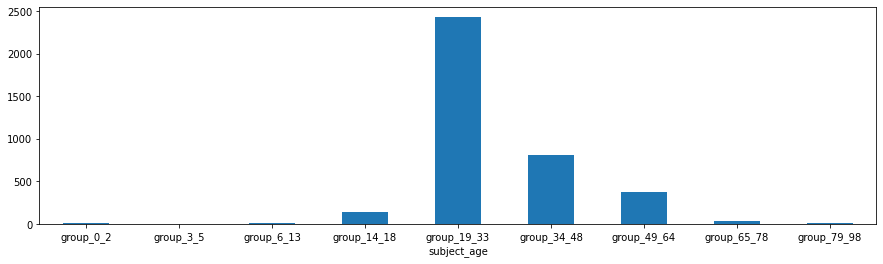

In [ ]:
age_assessment_counts[0].plot.bar(rot=0)

<AxesSubplot:xlabel='subject_age'>

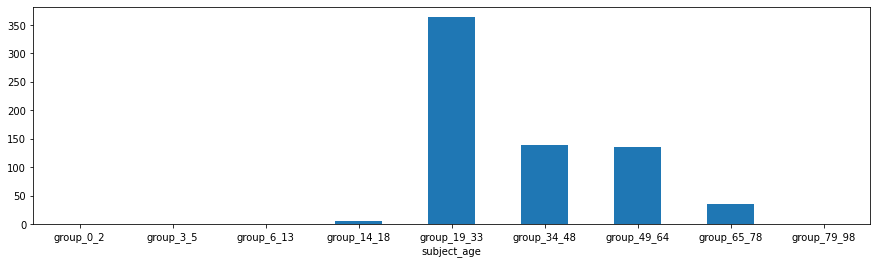

In [ ]:
age_assessment_counts[1].plot.bar(rot=0)

# Biến đổi dataframe về định dạng hợp lý để dùng trong model
- Chuyển về ordinal semantic cho cột age, smoke,...
- Tạo cột kiểu binary cho các cột trên
- Các cột giá trị list chuyển về multi label (cần nhớ giá trị NaN vẫn giữ nguyên)

In [ ]:
medical_condition_choice_df = pd.get_dummies(final_train_meta_merge['medical_condition_choice'].apply(pd.Series).stack()).sum(level=0)
# Drop no vì mấy cột kia sẽ bằng 0 hết
medical_condition_choice_df = medical_condition_choice_df.drop(columns=['No'])
medical_condition_choice_df

angina  asthma  diabetes  hbp  hiv  longterm  organ  otherHeart  stroke
0          0       0         0    0    0         0      0           0       0
2          0       0         0    0    0         0      0           0       0
4          0       0         0    0    0         0      0           0       0
8          0       0         0    0    0         0      0           0       0
23         0       0         0    0    0         0      0           0       0
...      ...     ...       ...  ...  ...       ...    ...         ...     ...
4471       0       0         0    0    0         0      1           0       0
4472       0       0         0    0    0         0      0           0       0
4482       0       0         0    0    0         0      0           0       0
4487       0       0         0    0    0         0      0           0       0
4491       0       0         0    0    0         0      0           0       0

[910 rows x 9 columns]

In [ ]:
symptoms_status_choice = pd.get_dummies(final_train_meta_merge['symptoms_status_choice'].apply(pd.Series).stack()).sum(level=0)
# Drop no vì mấy cột kia sẽ bằng 0 hết
# Nếu No == 1 mà mấy cột kia khác 0, drop vẫn ok vì cột No như này là sai
symptoms_status_choice = symptoms_status_choice.drop(columns=['No'])
symptoms_status_choice

chills  dizziness  drycough  ...  stuffynose  tightness  wetcough
0          0          0         0  ...           0          0         0
2          0          0         0  ...           0          0         0
4          0          0         0  ...           0          0         0
8          0          0         0  ...           0          0         0
23         0          0         0  ...           0          0         0
...      ...        ...       ...  ...         ...        ...       ...
4471       0          0         0  ...           0          0         0
4472       0          0         0  ...           0          0         0
4482       0          0         0  ...           0          0         0
4487       0          0         0  ...           0          0         0
4491       0          0         0  ...           0          0         0

[910 rows x 13 columns]

In [ ]:
sex_dummies = pd.get_dummies(final_train_meta_merge['subject_gender'])
sex_dummies

female  male
0          0     1
1          0     1
2          0     1
3          0     1
4          0     1
...      ...   ...
4499       0     1
4500       1     0
4501       1     0
4502       0     1
4503       0     1

[4504 rows x 2 columns]

In [ ]:
final_train_meta_merge = final_train_meta_merge.join([sex_dummies, medical_condition_choice_df, symptoms_status_choice])
final_train_meta_merge

uuid  subject_age  ... tightness wetcough
0     fc802bee-ef01-4496-a898-d7e77c0017e9  group_34_48  ...       0.0      0.0
1     9341db3f-049a-4ceb-8438-87ca1618a18a  group_34_48  ...       NaN      NaN
2     307e7a8b-b312-409e-ac01-75e1260b0a95  group_19_33  ...       0.0      0.0
3     ff8c21a8-4d05-43d8-96ee-dd33bcd6461e  group_19_33  ...       NaN      NaN
4     2e9d68e1-e84e-4aa5-8199-e7b0bbe6969f  group_19_33  ...       0.0      0.0
...                                    ...          ...  ...       ...      ...
4499  7e260fb9-7eb1-4433-99e0-dbbc05d2f2b2  group_34_48  ...       NaN      NaN
4500  c936f1a1-f6cf-48e5-82a1-872a58b6fd01  group_19_33  ...       NaN      NaN
4501  bacedca5-4147-4e87-ad70-2f0eb98f062d  group_49_64  ...       NaN      NaN
4502  90a9d310-0a13-493f-b476-c961a2d0c8c9  group_34_48  ...       NaN      NaN
4503  f616cb8d-370f-43e6-b459-121a9b987c94  group_19_33  ...       NaN      NaN

[4504 rows x 35 columns]

In [ ]:
final_train_meta_merge.drop(columns=['subject_gender', 'symptoms_status_choice','medical_condition_choice'], inplace=True)
final_train_meta_merge

uuid  subject_age  ... tightness wetcough
0     fc802bee-ef01-4496-a898-d7e77c0017e9  group_34_48  ...       0.0      0.0
1     9341db3f-049a-4ceb-8438-87ca1618a18a  group_34_48  ...       NaN      NaN
2     307e7a8b-b312-409e-ac01-75e1260b0a95  group_19_33  ...       0.0      0.0
3     ff8c21a8-4d05-43d8-96ee-dd33bcd6461e  group_19_33  ...       NaN      NaN
4     2e9d68e1-e84e-4aa5-8199-e7b0bbe6969f  group_19_33  ...       0.0      0.0
...                                    ...          ...  ...       ...      ...
4499  7e260fb9-7eb1-4433-99e0-dbbc05d2f2b2  group_34_48  ...       NaN      NaN
4500  c936f1a1-f6cf-48e5-82a1-872a58b6fd01  group_19_33  ...       NaN      NaN
4501  bacedca5-4147-4e87-ad70-2f0eb98f062d  group_49_64  ...       NaN      NaN
4502  90a9d310-0a13-493f-b476-c961a2d0c8c9  group_34_48  ...       NaN      NaN
4503  f616cb8d-370f-43e6-b459-121a9b987c94  group_19_33  ...       NaN      NaN

[4504 rows x 32 columns]

In [ ]:
age_map = {'group_0_2': 1, 
           'group_3_5': 2,
           'group_6_13': 3,
           'group_14_18': 4,
           'group_19_33': 5,
           'group_34_48': 6,
           'group_49_64': 7,
           'group_65_78': 8,
           'group_79_98': 9
           }

smoke_map = {
    'never': 0,
    'ex': 1,
    'ltOnce': 2,
    '1to10': 3,
    '11to20': 4,
    '21+': 5,
    'ecig': 6
}

insomnia_map = {
    'No': 0,
    'Onceper2Weeks': 1,
    '2to3': 2,
    '1': 3,
    '4+': 4
}

final_train_meta_merge.replace({'subject_age': age_map, 'smoke_status_choice': smoke_map, 'insomnia_status_choice': insomnia_map})

uuid  subject_age  ... tightness wetcough
0     fc802bee-ef01-4496-a898-d7e77c0017e9            6  ...       0.0      0.0
1     9341db3f-049a-4ceb-8438-87ca1618a18a            6  ...       NaN      NaN
2     307e7a8b-b312-409e-ac01-75e1260b0a95            5  ...       0.0      0.0
3     ff8c21a8-4d05-43d8-96ee-dd33bcd6461e            5  ...       NaN      NaN
4     2e9d68e1-e84e-4aa5-8199-e7b0bbe6969f            5  ...       0.0      0.0
...                                    ...          ...  ...       ...      ...
4499  7e260fb9-7eb1-4433-99e0-dbbc05d2f2b2            6  ...       NaN      NaN
4500  c936f1a1-f6cf-48e5-82a1-872a58b6fd01            5  ...       NaN      NaN
4501  bacedca5-4147-4e87-ad70-2f0eb98f062d            7  ...       NaN      NaN
4502  90a9d310-0a13-493f-b476-c961a2d0c8c9            6  ...       NaN      NaN
4503  f616cb8d-370f-43e6-b459-121a9b987c94            5  ...       NaN      NaN

[4504 rows x 32 columns]

# Test thử dataset hoàn thiện

## Implement

In [ ]:
## check_integrity.py
from typing import Optional, Any
import hashlib
import os

def calculate_md5(fpath: str, chunk_size: int = 1024 * 1024) -> str:
    # Src: pytorch/vision/utils
    md5 = hashlib.md5()
    with open(fpath, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''):
            md5.update(chunk)
    return md5.hexdigest()


def check_md5(fpath: str, md5: str, **kwargs: Any) -> bool:
    # Src: pytorch/vision/utils
    return md5 == calculate_md5(fpath, **kwargs)


def check_integrity(fpath: str, md5: Optional[str] = None) -> bool:
    # Src: pytorch/vision/utils
    if not os.path.isfile(fpath):
        return False
    if md5 is None:
        return True
    return check_md5(fpath, md5)

In [ ]:
from urllib.parse import urlparse
from typing import Optional
import re

def _get_google_drive_file_id(url: str) -> Optional[str]:
    # Src: pytorch/vision/utils
    parts = urlparse(url)

    if re.match(r"(drive|docs)[.]google[.]com", parts.netloc) is None:
        return None

    match = re.match(r"/file/d/(?P<id>[^/]*)", parts.path)
    if match is None:
        return None

    return match.group("id")

In [ ]:
import torchaudio

'''
  Read audio from given path and return (wave, sample_rate)
'''
def read_audio(full_audio_path):
  return torchaudio.load(full_audio_path)

'''
  Read audio from given path, then resample if sample rate is not matched 
  and return wave.

  Tips: 
    you should provide resampler from torchaudio.transform
    when batch resampling with same params since this can
    give a huge speed up.
'''
def read_resample_audio(
    full_audio_path, resample,
    resampler=None
):
  wave, sr = torchaudio.load(full_audio_path)
  if resampler is not None:
      wave = resampler(wave)
  elif sr != resample:
      wave = torchaudio.functional.resample(wave, sr, resample)
  return wave

In [ ]:
from torch.utils.data import Dataset
from typing import Any, Callable, Dict, List, Optional, Tuple
from tqdm import tqdm
import tempfile, shutil
import weakref
import pickle
import warnings
import ast

from sklearn.model_selection import train_test_split


class AICOVIDDataset(Dataset):
    '''
    AICOVID dataset made easy
    '''

    available_splits = ["w_pub_train", "w_pub_test", "w_pri_test", "f_pub_train", "f_pub_test", "f_pri_test"]

    official_urls = {
        "w_pub_train": "https://drive.google.com/file/d/1MPhz3zYl2yefCq-J5XySbFJt99BfKIZD/view",
        "w_pub_test": "https://drive.google.com/file/d/1UrMudzopA3CyR1Ih2J63Kfi2mY_0uhRK/view",
        "w_pri_test": "https://drive.google.com/file/d/1hP8rHwJ_bz3J1T4MtEEp53ZBe9fdFKrW/view",
        "f_pub_train": "https://drive.google.com/file/d/1Oq9UgA9cEGMNRGvF7oNKkFOg6udsDprl/view",
        "f_pub_test": "https://drive.google.com/file/d/159SghfGeqVj3AfgTRZXsAAAj0-3ogccX/view",
        "f_pri_test": None
    }

    mirrored_urls = {
        "w_pub_train": "https://drive.google.com/file/d/1hoGLxjLmPY-pX-jSVGIaWIZhovQBMKU1/view",
        "w_pub_test": "https://drive.google.com/file/d/1X7vOjHos9f9w48-iTWyu5JElFqCjcH_R/view",
        "w_pri_test": "https://drive.google.com/file/d/1Ec64sSm2dZqe3da_LVyE_jUBD0DnLyqB/view",
        "f_pub_train": "https://drive.google.com/file/d/1HoRJllAfYNeBPoCz2nXkf7lQ3raPcFYf/view",
        "f_pub_test": "https://drive.google.com/file/d/1w5N5prH-uWqLvoSZnuY8TIqm_BBgN2ND/view",
        "f_pri_test": None
    }

    resources = {
        "w_pub_train": ("aicv115m_public_train.zip", None),
        "w_pub_test": ("aicv115m_public_test.zip", None),
        "w_pri_test": ("aicv115m_private_test.zip", None),
        "f_pub_train": ("aicv115m_final_public_train.zip", None),
        "f_pub_test": ("aicv115m_final_public_test.zip", None),
        "f_pri_test": None
    }

    audio_paths = {
        "w_pub_train": 'aicv115m_public_train/train_audio_files_8k/',
        "w_pub_test": 'aicv115m_public_test/public_test_audio_files_8k/',
        "w_pri_test": 'aicv115m_private_test/private_test_audio_files_8k/',
        "f_pub_train": 'aicv115m_final_public_train/public_train_audio_files/',
        "f_pub_test": 'aicv115m_final_public_test/public_test_audio_files/',
        "f_pri_test": None
    }

    ############
    #   init
    ############

    def __init__(self, 
                 split: Optional[str]=None,
                 audio_transforms: torch.nn.ModuleList=None, 
                 chunking: Optional[Tuple[int, int]]=None,
                 val_split: Optional[bool]=None,
                 split_ratio: float=0.8,
                 cleanup_after: bool=True) -> None:
        
        if split is None: return  # Allow empty dataset for loading from gdrive later

        if split not in self.available_splits:
            raise NameError(f"{split} is not a valid split, please check again!")

        self.split = split
        self.download()

        self.meta_df = self.extract_archive()

        if val_split is not None:
            idx_train, idx_val = train_test_split(self.meta_df.index, train_size=split_ratio, random_state=1)
            self.meta_df = self.meta_df.iloc[idx_val if val_split else idx_train]

        # Create temporary folder to dump preprocessed data
        self._temp_folder = tempfile.mkdtemp()
        self._finalizer = weakref.finalize(self, shutil.rmtree, self._temp_folder)

        self.file_paths = []
        self.idxs = []
        self.chunk_idxs = None
        
        self.process_files(audio_transforms, chunking)
        
        if cleanup_after:
            self.cleanup_extract()


    ################################
    #   download/extract/cleanup
    ################################

    def _check_exists(self) -> bool:
        return check_integrity(*self.resources[self.split])


    def download(self) -> None:
        if self._check_exists():
            print("> Archive have already downloaded")
            return
        file_id = _get_google_drive_file_id(self.official_urls[self.split])
        os.system(f"gdown --id {file_id}")
        print("\n> Archive download complete")


    def extract_archive(self) -> pd.DataFrame:
        file_name, _ = self.resources[self.split]
        os.system(f"unzip -n -q {file_name}")
        print("\n> Extract complete")

        # split standardize (some split have different folder organize style)
        if self.split == "w_pub_train":
            os.system("unzip -n -q aicv115m_public_train/train_audio_files_8k.zip -d ./aicv115m_public_train")
            meta = pd.read_csv('aicv115m_public_train/metadata_train_challenge.csv').drop(columns=["file_path"])
        elif self.split == "w_pub_test":
            os.system("unzip -n -q aicv115m_public_test/public_test_audio_files_8k.zip -d /aicv115m_public_test")
            meta = pd.read_csv('aicv115m_public_test/metadata_public_test.csv').drop(columns=["file_path"])
        elif self.split == "w_pri_test":
            meta = pd.read_csv('aicv115m_private_test/metadata_private_test.csv').drop(columns=["file_path"])
        elif self.split == "f_pub_train":
            meta = pd.read_csv('aicv115m_final_public_train/public_train_metadata.csv')
            med_meta = pd.read_csv("aicv115m_final_public_train/public_train_medical_condition.csv")
            meta = meta.merge(med_meta, how="left", on="uuid")
            meta = self._process_final_meta(meta)
        elif self.split == "f_pub_test":
            meta = pd.read_csv('aicv115m_final_public_test/public_test_sample_submission.csv').drop(columns=["assessment_result"])
        elif self.split == "f_pri_test":
            pass

        return meta


    def _process_final_meta(self, meta):
        # Convert string in list/dict format to real list/dict object
        str_to_obj = lambda x: ast.literal_eval(x)
        col_tobe_processed = ['cough_intervals', 'symptoms_status_choice', 'medical_condition_choice',]
        for col in col_tobe_processed:
            meta[col] = meta[col].map(str_to_obj, na_action='ignore')

        # Process list type columns and categorical columns
        medical_condition_choice_df = pd.get_dummies(meta['medical_condition_choice'].apply(pd.Series).stack()).sum(level=0)
        medical_condition_choice_df = medical_condition_choice_df.drop(columns=['No'])
        symptoms_status_choice_df = pd.get_dummies(meta['symptoms_status_choice'].apply(pd.Series).stack()).sum(level=0)
        symptoms_status_choice_df = symptoms_status_choice_df.drop(columns=['No'])
        sex_dummies = pd.get_dummies(meta['subject_gender'])
        meta = meta.join([sex_dummies, medical_condition_choice_df, symptoms_status_choice_df])
        meta.drop(columns=['subject_gender', 'symptoms_status_choice','medical_condition_choice'], inplace=True)

        # Convert to ordinal values
        age_map = {'group_0_2': 1, 
                  'group_3_5': 2,
                  'group_6_13': 3,
                  'group_14_18': 4,
                  'group_19_33': 5,
                  'group_34_48': 6,
                  'group_49_64': 7,
                  'group_65_78': 8,
                  'group_79_98': 9
                  }

        smoke_map = {
            'never': 0,
            'ex': 1,
            'ltOnce': 2,
            '1to10': 3,
            '11to20': 4,
            '21+': 5,
            'ecig': 6
        }

        insomnia_map = {
            'No': 0,
            'Onceper2Weeks': 1,
            '2to3': 2,
            '1': 3,
            '4+': 4
        }

        meta = meta.replace({'subject_age': age_map, 
                             'smoke_status_choice': smoke_map, 
                             'insomnia_status_choice': insomnia_map})
        
        return meta


    def cleanup_extract(self) -> None:
        file_name, _ = self.resources[self.split]
        folder_name = file_name[:-4]  # Remove .zip part
        shutil.rmtree(folder_name)


    ##################
    #   read audio
    ##################

    def process_files(self,
                      audio_transforms: torch.nn.ModuleList=None, 
                      chunking: Optional[Tuple[int, int]]=None):
      
        audio_path = self.audio_paths[self.split]
        audio_files = audio_path + self.meta_df['uuid'] + '.wav'
        if chunking:
            self.chunk_idxs = []
            chunking = AudioChunking(*chunking, idx_instead=True)

        for id, file in enumerate(tqdm(audio_files)):
            specs = self._read_spec_audio(file, audio_transforms)
            if chunking:
                for spec in specs:
                    new_spec, chunk_idxs = chunking(spec)
                    paths = self._dump_to_disk([new_spec])
                    
                    self.file_paths += paths*len(chunk_idxs)
                    self.idxs += [id]*len(chunk_idxs)
                    self.chunk_idxs += chunk_idxs
            else:
                paths = self._dump_to_disk(specs)
                self.file_paths += paths
                self.idxs += [id]*len(paths)

        # Pickle for backup later
        with open(f"{self._temp_folder}/meta_df.pkl",'wb') as tmp:
            pickle.dump(self.meta_df, tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'wb') as tmp:
            pickle.dump(self.file_paths, tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'wb') as tmp:
            pickle.dump(self.idxs, tmp)
        with open(f"{self._temp_folder}/chunk_idxs.pkl",'wb') as tmp:
            if self.chunk_idxs is None:
                pickle.dump("None", tmp)
            else:
                pickle.dump(self.chunk_idxs, tmp)


    def _read_spec_audio(self, 
                         file: str,
                         transforms: torch.nn.ModuleList=None) -> list:
        wave = read_resample_audio(file, 8000).cuda()
        if transforms:
            specs = [trans(wave) for trans in transforms]
        else:
            specs = [wave]
        return specs

    def _dump_to_disk(self, specs: list or torch.Tensor) -> list:
        file_paths = []
        for spec in specs:
            fd, path = tempfile.mkstemp(suffix=".pt", dir=self._temp_folder)
            with os.fdopen(fd, 'wb') as tmp:
                # Clone to prevent view preserving of PyTorch
                # also moving tensor to cpu so when load up
                # pytorch will not moving them to gpu bebforehand!
                torch.save(spec.cpu(), tmp)
            file_paths.append(path)
        return file_paths


    ###################
    #   backup/load
    ###################

    def backup_to_drive(self, folder_id: str, upload_name: str):
        if self.meta_df is None:
            raise NamedError("Cannot backup an empty dataset.")
        
        os.system(f'zip -j ./{upload_name} {self._temp_folder}/*')
        drive.Upload(upload_name, folder_id)
        os.remove(upload_name)


    def load_from_drive(self, folder_id: str, backuped_name: str):
        drive.Download(backuped_name, folder_id)
        os.system(f'unzip -o {backuped_name} -d {self._temp_folder}')
        os.remove(backuped_name)
        with open(f"{self._temp_folder}/meta_df.pkl",'rb') as tmp:
            self.meta_df = pickle.load(tmp)
        with open(f"{self._temp_folder}/idxs.pkl",'rb') as tmp:
            self.idxs = pickle.load(tmp)
        with open(f"{self._temp_folder}/file_paths.pkl",'rb') as tmp:
            self.file_paths = pickle.load(tmp)
        with open(f"{self._temp_folder}/chunk_idxs.pkl",'rb') as tmp:
            self.chunk_idxs = pickle.load(tmp)
            if self.chunk_idxs == "None":
                self.chunk_idxs = None

        # Replace old tmp dir with current tmp dir
        for i, path in enumerate(self.file_paths):
            self.file_paths[i] = self._temp_folder+'/'+path.split('/')[-1]


    ################
    #   getitem
    ################

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spec = torch.load(self.file_paths[idx])
        if self.chunk_idxs:
            start, end = self.chunk_idxs[idx]
            spec = spec[..., start:end]

        meta = self.meta_df.iloc[self.idxs[idx]]
       
        label = meta.get('assessment_result')
        if label is not None:
            label = torch.tensor(label)
            meta = meta.drop('assessment_result')

        return spec, label, meta

## Test

In [ ]:
f_pub_train = AICOVIDDataset(split='f_pub_train')


> Archive download complete

> Extract complete


100%|██████████| 4504/4504 [00:52<00:00, 86.08it/s] 


In [ ]:
f_pub_train[0]

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -6.4433e-05,
          -1.4007e-05,  3.6955e-06]]),
 tensor(0),
 uuid                      fc802bee-ef01-4496-a898-d7e77c0017e9
 subject_age                                                  6
 audio_noise_note                                           NaN
 cough_intervals                                            NaN
 smoke_status_choice                                          0
 insomnia_status_choice                                       0
 female                                                       0
 male                                                         1
 angina                                                       0
 asthma                                                       0
 diabetes                                                     0
 hbp                                                          0
 hiv                                                          0
 longterm                                        

In [ ]:
t = f_pub_train[0][2].drop('uuid')
t

subject_age                 6
audio_noise_note          NaN
cough_intervals           NaN
smoke_status_choice         0
insomnia_status_choice      0
female                      0
male                        1
angina                      0
asthma                      0
diabetes                    0
hbp                         0
hiv                         0
longterm                    0
organ                       0
otherHeart                  0
stroke                      0
chills                      0
dizziness                   0
drycough                    0
fever                       0
headache                    0
muscleache                  0
shortbreath                 0
smelltasteloss              0
snivel                      0
sorethroat                  0
stuffynose                  0
tightness                   0
wetcough                    0
Name: 0, dtype: object

In [ ]:
torch.tensor(f_pub_train[0][2].drop('uuid'))

tensor([6., nan, nan, 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [ ]:
f_test_train = AICOVIDDataset(split='f_pub_test')


> Archive download complete


  1%|▏         | 16/1233 [00:00<00:07, 157.08it/s]


> Extract complete


100%|██████████| 1233/1233 [00:10<00:00, 120.94it/s]


In [ ]:
f_test_train[0]

(tensor([[ 0.0009,  0.0018, -0.0008,  ..., -0.0030,  0.0055,  0.0022]]),
 None,
 uuid    7b3797b0-3b7e-41e3-8b28-e2717eb55f8b
 Name: 0, dtype: object)